In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean
import arrow

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

#### Goal is to check the 201905 re-runs (which I am using for my NPGO paper) and production runs to see if they match up. If so, use any available 2022 files to look at SOPO results

### Comparison of Temperature between 201905 re-run and production run

In [3]:
#years, months, data
monthly_array_temp_RR_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021,2022), ['votemper']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

#Re-run 201905 (what I've been using for NPGO paper)
for year in [2021]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.votemper.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_temp_RR_slice[year-2021,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['votemper']:
                data[var].append(ds.votemper.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

              


In [4]:
monthly_array_temp_RR_slice[monthly_array_temp_RR_slice == 0 ] = np.nan
monthly_array_temp_RR_slicemean = \
np.nanmean(np.nanmean(monthly_array_temp_RR_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_temp_RR_slicemean))

(1, 12)


In [5]:
monthly_array_temp_RR_slicemean

array([[ 6.69923044,  5.97016817,  7.16365076, 10.14811757, 14.06956819,
        17.78126071, 21.65835148, 20.45551644, 16.05875674, 11.59599946,
         8.83402965,  6.51791764]])

In [6]:
#years, months, data
monthly_array_temp_prod_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021, 2022), ['votemper']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
slc = {'gridY': slice(450,500), 'gridX': slice(250,300)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run


# Production 201905
for year in [2021]:
    jan = arrow.get(f"{year}-01-01")
    dec = arrow.get(f"{year}-12-01")
    
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    months = arrow.Arrow.range("month", jan,dec)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_grid_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
    
        # Load grazing variables
        with xr.open_dataset(ds_file) as ds:
            q = ds.votemper.isel(depth=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_temp_prod_slice[year-2021,month.month-1,:,:] = q2 #month.month changes arrow object to integer
            for var in ['votemper']:
                data[var].append(ds.votemper.isel(depth=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)



In [7]:
monthly_array_temp_prod_slice[monthly_array_temp_prod_slice == 0 ] = np.nan
monthly_array_temp_prod_slicemean = \
np.nanmean(np.nanmean(monthly_array_temp_prod_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_temp_prod_slicemean))

(1, 12)


In [8]:
monthly_array_temp_prod_slicemean

array([[ 6.69923043,  5.97016817,  7.16365077, 10.14811757, 14.06956817,
        17.78126071, 21.65835151, 20.45551642, 16.05875673, 11.59599944,
         8.83402967,  6.51791764]])

Text(0, 0.5, 'Degrees C')

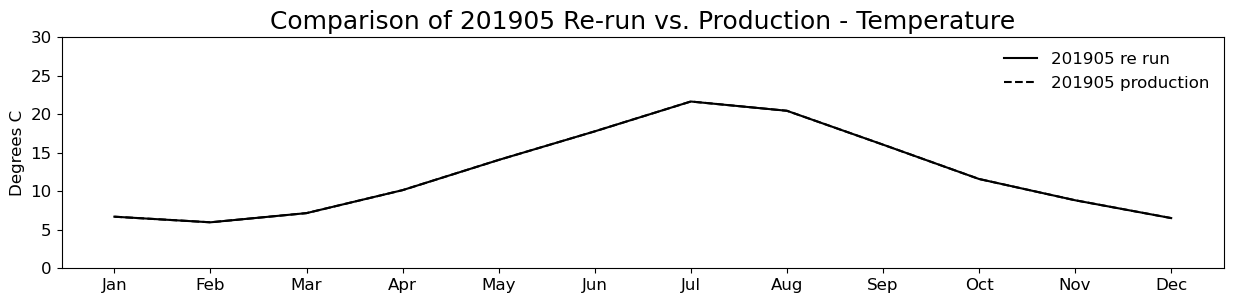

In [9]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]


ax.plot(xticks, monthly_array_temp_RR_slicemean[0,:],color='k',linestyle='-',label='201905 re run')
ax.plot(xticks, monthly_array_temp_prod_slicemean[0,:],color='k',linestyle='--',label='201905 production')


ax.set_title('Comparison of 201905 Re-run vs. Production - Temperature',fontsize=18)
ax.legend(frameon=False,loc=1)
ax.set_ylim(0,30)
ax.set_ylabel('Degrees C')

In [10]:
### Comparison of PAR between 201905 re-run and production run

In [11]:
#years, months, data
monthly_array_PAR_RR_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021,2022), ['PAR']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

#Re-run 201905 (what I've been using for NPGO paper)
for year in [2021]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_carp_T.nc') as ds:
            q = ds.PAR.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_PAR_RR_slice[year-2021,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['PAR']:
                data[var].append(ds.PAR.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

              


In [12]:
monthly_array_PAR_RR_slice[monthly_array_PAR_RR_slice == 0 ] = np.nan
monthly_array_PAR_RR_slicemean = \
np.nanmean(np.nanmean(monthly_array_PAR_RR_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_PAR_RR_slicemean))

(1, 12)


In [13]:
monthly_array_PAR_RR_slicemean

array([[ 12.76428907,  22.18004067,  43.90109428,  68.86413115,
         83.72060833,  99.57996742, 106.36866222,  83.17137149,
         49.04399966,  26.90667953,  11.47426772,  12.01072482]])

In [14]:
#years, months, data
monthly_array_PAR_prod_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021, 2022), ['PAR']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
slc = {'gridY': slice(450,500), 'gridX': slice(250,300)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run


# Production 201905
for year in [2021]:
    jan = arrow.get(f"{year}-01-01")
    dec = arrow.get(f"{year}-12-01")
    
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    months = arrow.Arrow.range("month", jan,dec)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_carp_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
    
        # Load grazing variables
        with xr.open_dataset(ds_file) as ds:
            q = ds.PAR.isel(depth=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_PAR_prod_slice[year-2021,month.month-1,:,:] = q2 #month.month changes arrow object to integer
            for var in ['PAR']:
                data[var].append(ds.PAR.isel(depth=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)



In [15]:
monthly_array_PAR_prod_slice[monthly_array_PAR_prod_slice == 0 ] = np.nan
monthly_array_PAR_prod_slicemean = \
np.nanmean(np.nanmean(monthly_array_PAR_prod_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_PAR_prod_slicemean))

(1, 12)


In [16]:
monthly_array_PAR_prod_slicemean

array([[ 12.76428906,  22.18004067,  43.90109421,  68.86413129,
         83.72060844,  99.57996745, 106.36866223,  83.17137153,
         49.04399962,  26.90667951,  11.47426769,  12.01072483]])

Text(0, 0.5, 'm$^{-2}$')

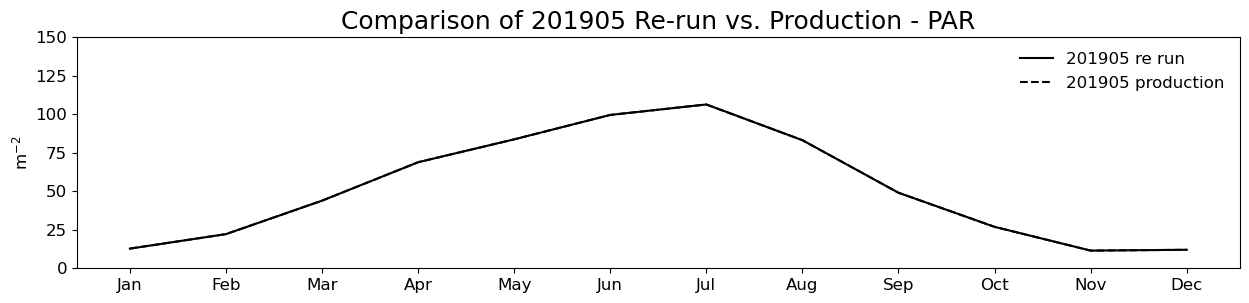

In [17]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]


ax.plot(xticks, monthly_array_PAR_RR_slicemean[0,:],color='k',linestyle='-',label='201905 re run')
ax.plot(xticks, monthly_array_PAR_prod_slicemean[0,:],color='k',linestyle='--',label='201905 production')


ax.set_title('Comparison of 201905 Re-run vs. Production - PAR',fontsize=18)
ax.legend(frameon=False,loc=1)
ax.set_ylim(0,150)
ax.set_ylabel('m$^{-2}$')

### Comparison of Nitrate between 201905 re-run and production run

In [18]:
#years, months, data
monthly_array_nitrate_RR_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 20),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021,2022), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

#Re-run 201905 (what I've been using for NPGO paper)
for year in [2021]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data
    # Concatenate months
            q2 = q[0,:,:]
            monthly_array_nitrate_RR_slice[year-2021,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var in ['nitrate']:
                data[var].append((ds[var].isel(deptht=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

              


In [19]:
monthly_array_nitrate_RR_slice[monthly_array_nitrate_RR_slice == 0 ] = np.nan
monthly_array_nitrate_RR_slicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_RR_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_RR_slicemean))

(1, 12)


In [20]:
monthly_array_nitrate_RR_slicemean

array([[24.3994864 , 23.9651713 , 23.29073882, 16.6678465 , 11.46316386,
         8.38415251,  7.22542155, 10.1437083 , 15.42586805, 21.89879064,
        22.64868345, 23.31639192]])

In [21]:
#years, months, data
monthly_array_nitrate_prod_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 20),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021, 2022), ['nitrate']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
slc = {'gridY': slice(450,500), 'gridX': slice(250,300)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run


# Production 201905
for year in [2021]:
    jan = arrow.get(f"{year}-01-01")
    dec = arrow.get(f"{year}-12-01")
    
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    months = arrow.Arrow.range("month", jan,dec)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_ptrc_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
    
        # Load grazing variables
        with xr.open_dataset(ds_file) as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(depth=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data
            q2 = q[0,:,:]
            monthly_array_nitrate_prod_slice[year-2021,month.month-1,:,:] = q2 #month.month changes arrow object to integer
            for var in ['nitrate']:
                data[var].append((ds[var].isel(depth=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)



In [22]:
monthly_array_nitrate_prod_slice[monthly_array_nitrate_prod_slice == 0 ] = np.nan
monthly_array_nitrate_prod_slicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_prod_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_prod_slicemean))

(1, 12)


In [23]:
monthly_array_nitrate_prod_slicemean

array([[24.3994864 , 23.96517128, 23.29073882, 16.66784649, 11.46316386,
         8.38415251,  7.22542155, 10.14370829, 15.42586805, 21.89879065,
        22.64868346, 23.31639193]])

Text(0, 0.5, 'μmol N m$^{-3}$')

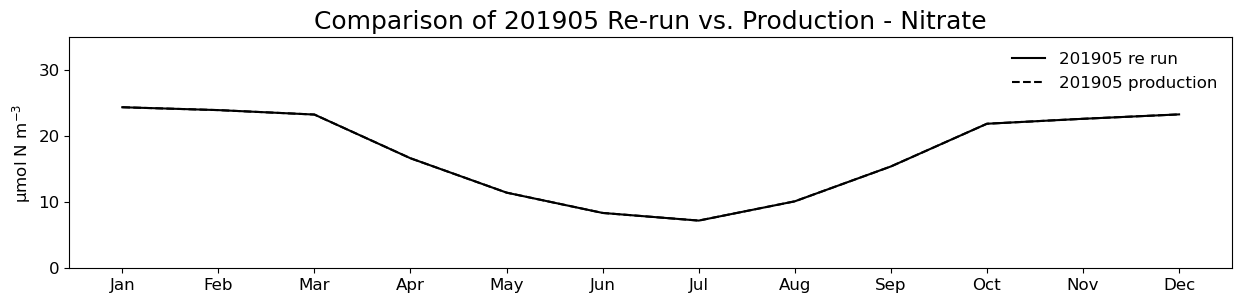

In [24]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]


ax.plot(xticks, monthly_array_nitrate_RR_slicemean[0,:],color='k',linestyle='-',label='201905 re run')
ax.plot(xticks, monthly_array_nitrate_prod_slicemean[0,:],color='k',linestyle='--',label='201905 production')


ax.set_title('Comparison of 201905 Re-run vs. Production - Nitrate',fontsize=18)
ax.legend(frameon=False,loc=1)
ax.set_ylim(0,35)
ax.set_ylabel('\u03bcmol N m$^{-3}$')

### Comparison of Silicon between 201905 re-run and production run

In [25]:
#years, months, data
monthly_array_silicon_RR_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 20),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021,2022), ['silicon']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

#Re-run 201905 (what I've been using for NPGO paper)
for year in [2021]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data
    # Concatenate months
            q2 = q[0,:,:]
            monthly_array_silicon_RR_slice[year-2021,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var in ['silicon']:
                data[var].append((ds[var].isel(deptht=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

              


In [26]:
monthly_array_silicon_RR_slice[monthly_array_silicon_RR_slice == 0 ] = np.nan
monthly_array_silicon_RR_slicemean = \
np.nanmean(np.nanmean(monthly_array_silicon_RR_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_silicon_RR_slicemean))

(1, 12)


In [27]:
monthly_array_silicon_RR_slicemean

array([[48.3092788 , 48.65005187, 47.70038113, 35.01914953, 19.45267358,
        16.16953464, 17.75242325, 22.58933071, 30.59953971, 39.17609432,
        43.29324065, 45.56209756]])

In [28]:
#years, months, data
monthly_array_silicon_prod_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 20),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021, 2022), ['silicon']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
slc = {'gridY': slice(450,500), 'gridX': slice(250,300)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run


# Production 201905
for year in [2021]:
    jan = arrow.get(f"{year}-01-01")
    dec = arrow.get(f"{year}-12-01")
    
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    months = arrow.Arrow.range("month", jan,dec)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_ptrc_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
    
        # Load grazing variables
        with xr.open_dataset(ds_file) as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(depth=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data
            q2 = q[0,:,:]
            monthly_array_silicon_prod_slice[year-2021,month.month-1,:,:] = q2 #month.month changes arrow object to integer
            for var in ['silicon']:
                data[var].append((ds[var].isel(depth=slice(None, 20),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)



In [29]:
monthly_array_silicon_prod_slice[monthly_array_silicon_prod_slice == 0 ] = np.nan
monthly_array_silicon_prod_slicemean = \
np.nanmean(np.nanmean(monthly_array_silicon_prod_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_silicon_prod_slicemean))

(1, 12)


In [30]:
monthly_array_silicon_prod_slicemean

array([[48.3092788 , 48.65005186, 47.70038113, 35.01914954, 19.45267358,
        16.16953464, 17.75242325, 22.58933071, 30.59953971, 39.17609433,
        43.29324065, 45.56209755]])

Text(0, 0.5, 'μmol N m$^{-3}$')

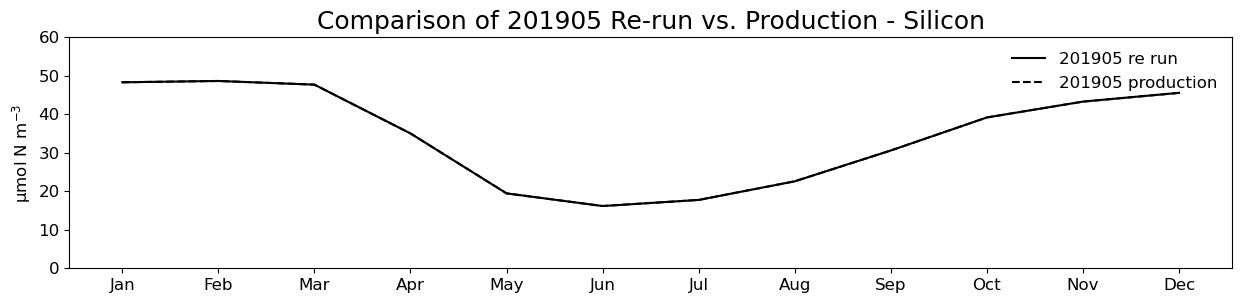

In [31]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]


ax.plot(xticks, monthly_array_silicon_RR_slicemean[0,:],color='k',linestyle='-',label='201905 re run')
ax.plot(xticks, monthly_array_silicon_prod_slicemean[0,:],color='k',linestyle='--',label='201905 production')


ax.set_title('Comparison of 201905 Re-run vs. Production - Silicon',fontsize=18)
ax.legend(frameon=False,loc=1)
ax.set_ylim(0,60)
ax.set_ylabel('\u03bcmol N m$^{-3}$')

### Comparison of Diatoms between 201905 re-run and production run

In [32]:
#years, months, data
monthly_array_diatoms_RR_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021,2022), ['diatoms']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

#Re-run 201905 (what I've been using for NPGO paper)
for year in [2021]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_diatoms_RR_slice[year-2021,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var in ['diatoms']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

              


In [33]:
monthly_array_diatoms_RR_slice[monthly_array_diatoms_RR_slice == 0 ] = np.nan
monthly_array_diatoms_RR_slicemean = \
np.nanmean(np.nanmean(monthly_array_diatoms_RR_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_diatoms_RR_slicemean))

(1, 12)


In [34]:
monthly_array_diatoms_RR_slicemean

array([[ 0.161966  ,  0.08143424,  1.59819473, 37.13405245, 26.01830472,
        14.71278651, 10.61453493,  4.82263473,  0.6055536 ,  0.41080683,
         0.23443159,  0.14029651]])

In [35]:
#years, months, data
monthly_array_diatoms_prod_slice = np.zeros([1,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2021, 2022), ['diatoms']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
slc = {'gridY': slice(450,500), 'gridX': slice(250,300)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run


# Production 201905
for year in [2021]:
    jan = arrow.get(f"{year}-01-01")
    dec = arrow.get(f"{year}-12-01")
    
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    months = arrow.Arrow.range("month", jan,dec)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_ptrc_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
    
        # Load grazing variables
        with xr.open_dataset(ds_file) as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(depth=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_diatoms_prod_slice[year-2021,month.month-1,:,:] = q2 #month.month changes arrow object to integer
            for var in ['diatoms']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(depth=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)



In [36]:
monthly_array_diatoms_prod_slice[monthly_array_diatoms_prod_slice == 0 ] = np.nan
monthly_array_diatoms_prod_slicemean = \
np.nanmean(np.nanmean(monthly_array_diatoms_prod_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_diatoms_prod_slicemean))

(1, 12)


In [37]:
monthly_array_diatoms_prod_slicemean

array([[ 0.161966  ,  0.08143424,  1.59819473, 37.13405246, 26.01830471,
        14.71278651, 10.61453493,  4.82263473,  0.6055536 ,  0.41080683,
         0.23443159,  0.14029651]])

Text(0, 0.5, 'mmol N m$^{-2}$')

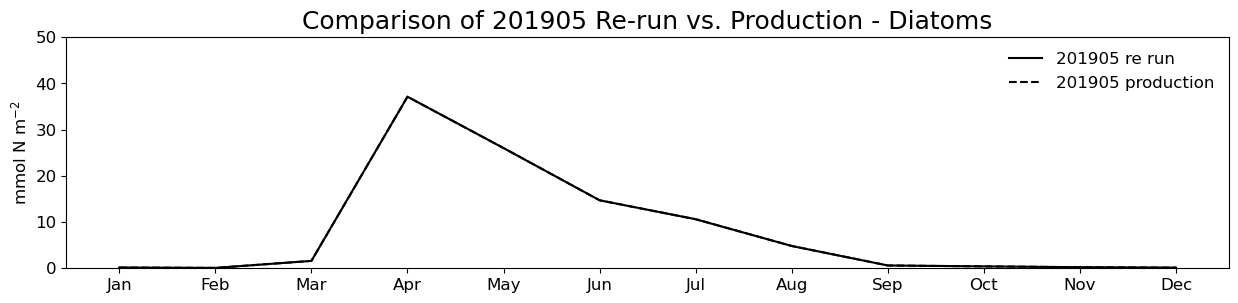

In [38]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]


ax.plot(xticks, monthly_array_diatoms_RR_slicemean[0,:],color='k',linestyle='-',label='201905 re run')
ax.plot(xticks, monthly_array_diatoms_prod_slicemean[0,:],color='k',linestyle='--',label='201905 production')


ax.set_title('Comparison of 201905 Re-run vs. Production - Diatoms',fontsize=18)
ax.legend(frameon=False,loc=1)
ax.set_ylim(0,50)
ax.set_ylabel('mmol N m$^{-2}$')

### All parameters show an exact match between runs. Okay to use monthly 201905 production run files to look at SOPO year 2022 compared to the rest of the time series.